# Graph Fourier transform

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import cv2
import pandas as pd
import geopandas
from sklearn.neighbors import NearestNeighbors
from copy import copy
from scipy.sparse.linalg import eigsh
from math import factorial

from src.GFT_utils import *

import warnings
warnings.filterwarnings('ignore')

## Diffusion on a graph


We perform a simple example of diffusion of a signal initialized to a Kroeneker delta on a graph with communities. We generate a graph from the stochastic block model that we will introduce in the lecture on community detection. 

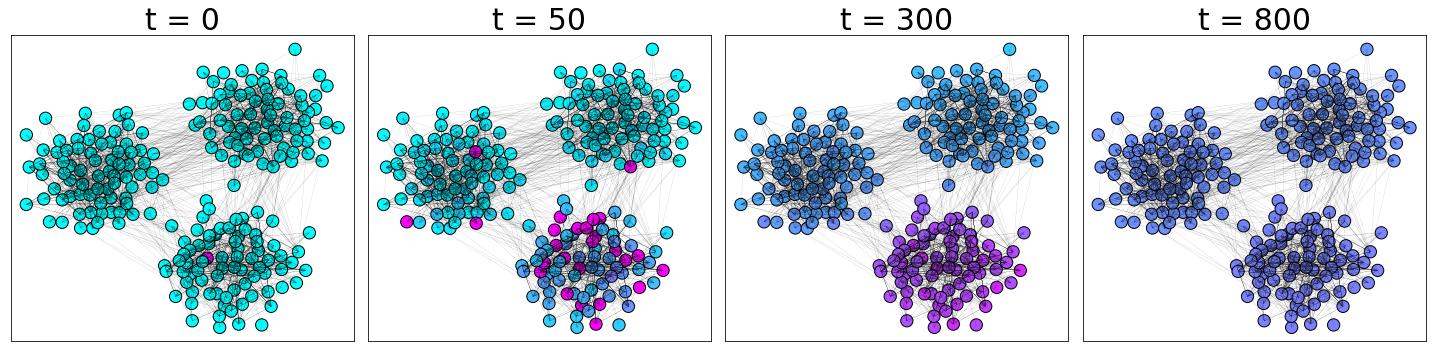

In [2]:
# generate the graph 

sizes = [75, 75, 75]
probs = [[0.25, 0.02, 0.02], [0.02, 0.25, 0.02], [0.02, 0.02, 0.25]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

# get the adjacency matrix
A = nx.adjacency_matrix(G)
n, _ = A.shape

# initialize the parameters
u = np.zeros(n)
u[10] = 100
α = 1
dt = 0.001
T = 1000

# run the simulation 
ut = GraphDiffusion(A, u, α, dt, T)

# plot
time_indeces = [0, 50, 300, 800]
PlotDiffusion(G, ut, time_indeces)


## Tikhonov regularization

We consider an input image of the Gioconda painting and keep only 10% of its pixels. We then use Tikhonov regularization to reconstruct the missing pixels creating a grid graph connecting each pixel to its neighbors.

In [3]:
# upload image
img = cv2.imread('Data/ML.jpg')

# convert it to black and white
bw_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,::,2]*0.114)/255

# flatten the image
y = bw_img.flatten()
n = len(y)

# an entry is observed with probability p
p = 0.1
idx = np.random.binomial(1, p, n) == 1
y[~idx] = 1

# get a grid on the picture and build the Laplacian matrix
A, mapper = GetSquareGrid(bw_img.shape)
d = A@np.ones(n)
D = diags(d)
L = D - A

# Tikhonov regularitation
γ = 1
y_reg = Tikhonov(y, idx, γ, L)

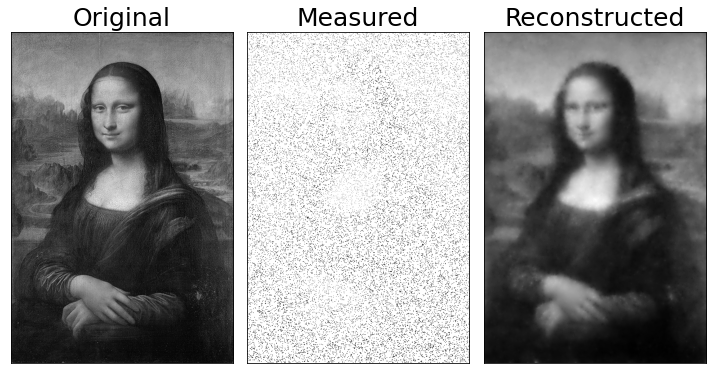

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (10, 8))

ax[0].imshow(bw_img, cmap = 'gray')
ax[1].imshow(y.reshape(bw_img.shape), cmap = 'gray')
ax[2].imshow(y_reg.reshape(bw_img.shape), cmap = 'gray')

titles = ['Original', 'Measured', 'Reconstructed']

for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(titles[i], fontsize = 25)

plt.tight_layout()
# plt.savefig('ML.png', dpi = 400)
plt.show();

## Filtering a signal

We now use the NYC taxi dataset containing several information about taxi drives, including region (of NYC) of origin and destination and fare of the ride. These data can be found [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The city is divided in approximately $300$ regions and we compute the average fare of the destination for each origin. This signal signal is strongly auto-correlated, meaning that nearby regions have similar average fares to be paid. We now introduce some noise in this dataset, taking a random sample including 25% of the total number of regions and randomly reassigning them the average fare amount. Our goal is to reconstruct the original signal by filtering out the high frequency components introduced by noise and exploiting geometrical proximity to smooth the signal. 

From the dataset we can extract the coordinates of the centroid of each region and use that to build a graph. We generate it using a fast $k$ nearest neighbors algorithm that connects each node $i$ to its $k$ closest nodes. Note that the matrix we get in this way is not symmetric: Palermo and Roma are (probably) the closest provinces to Sassari, but the opposite is not true. We then must first symmetrize the adjacency matrix to get the correct representation of our graph.

We then design an exponential filter $e^{-\gamma x}$, exploiting its polynomial approximation, {i.e.}

\begin{align*}
f(x) = \sum_{a = 1}^p \frac{(-\gamma x)^a}{a!},
\end{align*}

for some $p$. As we know, the modulus of a polynomial function tends to infinity for $x \to\infty$ and is thus not a good approximation of the exponential function. Yet, the argument of the function is bounded by $\rho(L)\gamma$ and we must choose the order of the polynomial $p$ so that is well approximates the exponential function for all $x\in[0,\rho(L)\gamma]$.


### Step 1

We pre-process the dataset to get, for each region, the centroid coordinate and the average fare.

In [5]:
# load the taxi data and the shapefile
df_taxi = pd.read_parquet('Data/NYC_taxi.parquet', engine = 'fastparquet')
shape_file = geopandas.read_file('Data/taxi_zones.zip')

# compute the average fare in each region
df_taxi = df_taxi.groupby('DOLocationID').mean('fare_amount')

# add the fare column to the shape_file
shape_file['fare'] = shape_file.OBJECTID.map(lambda x: MapWithNaN(df_taxi, x, 'fare_amount'))

# remove missing entries
shape_file = shape_file.dropna()

# compute the centroid of each region and keep only the relevant columns
shape_file['x'] = shape_file.geometry.map(lambda x: x.centroid.x)
shape_file['y'] = shape_file.geometry.map(lambda x: x.centroid.y)
shape_file = shape_file[['geometry', 'x', 'y', 'fare']]

# now we introduce noise
shape_file['noisy_fare'] = copy(shape_file.fare)
idx = np.random.choice(shape_file.index, int(len(shape_file)/4), replace = False)
shape_file['noisy_fare'][idx] = np.random.uniform(20, 80, len(idx))

shape_file.head()

,geometry,x,y,fare,noisy_fare
0,"POLYGON ((933100.918 192536.086, 933091.011 19...",9.359968e+05,191376.749531,70.806098,70.806098
1,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",1.031086e+06,164018.754403,36.200000,30.681311
2,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",1.026453e+06,254265.478659,39.696117,39.696117
3,"POLYGON ((992073.467 203714.076, 992068.667 20...",9.906340e+05,202959.782391,10.724821,10.724821
4,"POLYGON ((935843.310 144283.336, 936046.565 14...",9.318714e+05,140681.351376,73.918182,73.918182


### Step 2

We construct the graph from the centroids

In [6]:
# in X we store the centroids coordinates
X = shape_file[['x', 'y']].values

# we then find the k = 4 nearest neighbors of each node and convert it to and edge list format
nbrs = NearestNeighbors(n_neighbors = 4, algorithm = 'ball_tree').fit(X)
_, indices = nbrs.kneighbors(X)

EL = []
for i, idx in enumerate(indices):
    for a in idx:
        EL.append([i, a])
EL = np.array(EL)

# we build the adjacency matrix, we symmetrize it and get the Laplacian matrix
n = len(np.unique(EL))
A = csr_matrix((np.ones(len(EL[:,0])), (EL[:,0], EL[:,1])), shape = (n,n))
A = (A + A.T).sign()
d = A@np.ones(n)
D = diags(d)
L = D - A

### Step 3

We test the filter approximation on our domain and find a good value $p$ to approximate the exponential decay. We obtain $p = 30$ is sufficient.

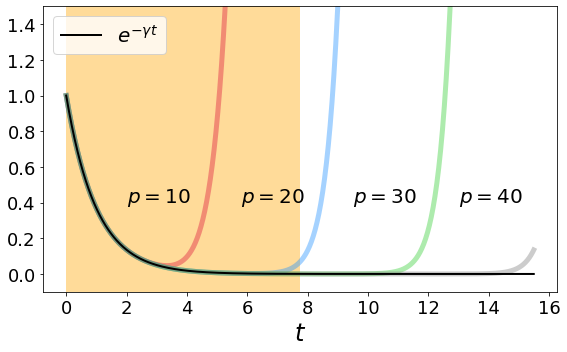

In [7]:
# filter construction

# we use γ = 1 and compute the spectral radius of L
ρ, _ = eigsh(L, k = 1, which = 'LA')
γ = 1.

# we define the coefficients of the polynomial approximation for p up to 40
coefficients = [(-γ)**p/factorial(p) for p in range(41)]

# we evaluate the approximation on an interval slightly larger than ρ*γ
t = np.linspace(0, 2*ρ*γ, 1000).flatten()

# here we store the approximations for p = 10, 20, 30, 40
S = [np.zeros(len(t)) for i in range(4)]

for i in range(len(coefficients)):
    for a in range(len(S)):
        if i <= 10*(a+1):
            S[a] += coefficients[i]*t**i

# plot
plt.figure(figsize = (8,5))

colors = ['crimson', 'dodgerblue', 'limegreen', 'grey']

for a in range(len(S)):
    plt.plot(t, S[a], color = colors[a], linewidth = 5, alpha = 0.4)

plt.plot(t, np.exp(-γ*t), color = 'k', linewidth = 2, label = r'$e^{-\gamma t}$')
plt.text(2.,0.4, r'$p = 10$', fontsize = 20)
plt.text(5.8,0.4, r'$p = 20$', fontsize = 20)
plt.text(9.5,0.4, r'$p = 30$', fontsize = 20)
plt.text(13.,0.4, r'$p = 40$', fontsize = 20)

plt.axvspan(0, ρ*γ, facecolor = 'orange', alpha=0.4)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.xlabel(r'$t$', fontsize = 24)

plt.ylim(-0.1, 1.5)
plt.legend(loc = 2, fontsize = 20)
plt.tight_layout()
# plt.savefig('Figures/filter.pdf', dpi = 400)
plt.show();

# consider p = 30
coefficients = np.array(coefficients)[:31]

### Step 4

We filter the signal and add it to the `shape_file` dataframe

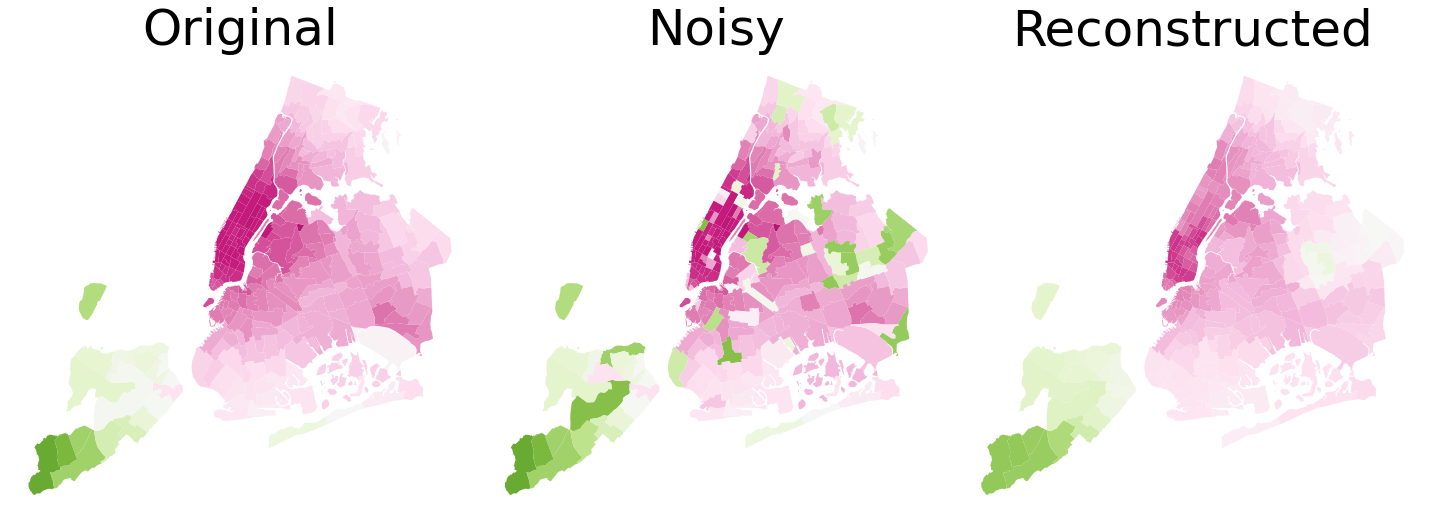

In [8]:
# the filter is applied to the noisy signal
y = [shape_file.noisy_fare.values]

# we iteratively multiply L for the vector L^ay
for i in range(len(coefficients)-1):
    y.append(L@y[-1])

# we obtain the regularized signal making the sum of all values in y, weighted by the filter coefficients
y_reg = np.zeros(len(y[0]))

for i in range(len(coefficients)):
    y_reg += y[i]*coefficients[i]

# we add the result to the shape_file dataframe
shape_file['cleaned_fare'] = y_reg


# PLOT
fig, ax = plt.subplots(1, 3, figsize = (20,7))

shape_file.plot(ax = ax[0], column = 'fare', cmap = 'PiYG', vmin = 0, vmax = 100)
shape_file.plot(ax = ax[1], column = 'noisy_fare', cmap = 'PiYG', vmin = 0, vmax = 100)
shape_file.plot(ax = ax[2], column = 'cleaned_fare', cmap = 'PiYG', vmin = 0, vmax = 100)

for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].axis('off')

ax[0].set_title('Original', fontsize = 50)
ax[1].set_title('Noisy', fontsize = 50)
ax[2].set_title('Reconstructed', fontsize = 50)

plt.tight_layout()
# plt.savefig('Figures/NYC.pdf', dpi = 400, bbox_inches = 'tight') 
plt.show();